# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os.path
import pandas as pd
from astroquery.splatalogue import Splatalogue  # We must acknowledge authors for use of this library
from astropy import units as u

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


# Data
The data comes from 4 text files.  Each file contains 2 columns of data, _frequency_ and _flux_.  We'll only need to read in the data if we don't already know which molecules could be contained within the frequencies (by running the code).

In [2]:
if os.path.isfile('./Data/all_molecules.csv'):
    print("\n --- Loading in data ---\n")
    all_molecules = pd.read_csv('./Data/all_molecules.csv', header = 0, index_col = 0).to_dict(orient = "index")
    generate_plot = False   # Whether or not to generate the plot
    print("\n --- Complete ---\n")
else:
    # read in the data
    print("\n --- Reading in data ---\n")
    filenames = ["./Data/Win0.clean1.contsub_Jy.rest.scom.c.txt",
                 "./Data/Win1.clean1.contsub_Jy.rest.scom.c.txt",
                 "./Data/Win2.clean1.contsub_Jy.rest.scom.c.txt",
                 "./Data/Win3.clean1.contsub_Jy.rest.scom.c.txt"]
    # 'data' will be a 4 element list, with each element representing the data from 1 text file
    data = [np.loadtxt(f) for f in filenames]
    generate_plot = True
    print("\n --- Complete ---\n")


 --- Reading in data ---


 --- Complete ---



# Functions

## create_plot()
This function will generate a figure with 4 axes and produce a plot of the frequency versus flux of the raw data.  It will then return the figure and handle to those axes.

In [3]:
def create_plot():
    """ Recreate the plot from Cordiner et. al. 2015, Figure 1 """
    # Defining the figure might need more finess if there are more than 4 datasets
    # We need to consult a domain expert to learn if ALMA data always comes back with 4 datasets
    fig, axs = plt.subplots(2, 2, figsize = (10, 6))
    for index, ax in enumerate(axs.flat):
        # Plot each data set
        ax.plot(data[index][:,0],
                data[index][:,1],
                linewidth = 0.25)
        ax.set(ylabel = "Flux (Jy)")
        ax.set(xlabel = "Frequency (GHz)")
        # Clean up the xticks
        ax.set_xticks(np.arange(round(data[index][0,0], 1), round(data[index][-1,0], 1), step = 0.5))
        # Remove the space from the borders of the plot along the X axis
        ax.autoscale(enable = True, axis = 'x', tight = True)
    # Add some space between the plots
    plt.subplots_adjust(hspace = .3, wspace = .3)
    return fig, axs

## add_lines(id, molecules)
This function adds dashed lines to a specified axis (`id`) at every frequency passed in by `molecules`.  `molecules` is a dictionary whose keys are the _frequencies_ above the 3$\sigma$ threshold and whose values are the _Chemical names_ of molecules that have a spectral line at that frequency, and also their _Molecule Tag_.  So each frequency will have a dictionary inside it with keys _Chemical Name_ and _Molecule Tag_ with values pulled from the results of a Splatalogue query.

In [4]:
def add_lines(id, molecules):
    """This function will add dashed lines to the plot where molecules were detected"""
    for freq in molecules.keys():
        axs[id].axvline(x = float(freq),
                        ymin = 0,
                        ymax = 1,
                        dashes = [18, 6],
                        linewidth = 0.25,
                        color = "gray",
                        alpha = 0.5)

## find_molecules()
This function constructs 2 dictionaries.  The first dictionary created is `molecules.`  `molecules` is a dictionary whose keys are the _frequencies_ above the 3$\sigma$ threshold and whose values are the _Chemical names_ of molecules that have a spectral line at that frequency, and also their _Molecule Tag_.  So each frequency will have a dictionary inside it with keys _Chemical Name_ and _Molecule Tag_ with values pulled from the results of a Splatalogue query.  `molecules` is unique to each axis on the figure.  That is, since there are 4 axes on the figure, `molecules` gets generated 4 times.  Each time those frequencies get passed to `add_lines(id, molecules)` along with the `id` of the axis that it is meant for.

The second dictionary is a global dictionary, `all_molecules`.  This dictionary's keys are the unique _Chemical Names_ identified from all 4 generations of the `molecules` dictionary.  The values are another dictionary with keys _Occurances_, _Molecule Tag_, and _Linelist_ whose values are the frequencies of spectral emissions this molecule was found at in the data, the molecule tag number, and the linelist representing what database the data was pulled from, respectively.

The `molecules` dictionary is generated by first identifying all frequencies where the flux exceeds the 3$\sigma$ threshold (where a flux value is greater than 3 standard deviations away from the mean).  Then, for each frequency that meets this criteria, a query to the Splatalogue API is made at that frequency $\pm$ some `delta` (initially set to 50kHz).  If the query returns any results, they are added to the `molecules` and `all_molecules` dictionarys.

In [5]:
def find_molecules():
    """ Classify the molecules from their frequency for each dataset """
    for id, dataset in enumerate(data):
        # Locate the indices where the flux is greater than 3 standard deviations
        # There are 4 datasets.  Column 0 is the frequency, column 1 is the flux
        # Splatalogue appears to be accurate up to 5 decimal places
        molecules = {}  # An empty dictionary to store the results of each detected molecule and rest frequency
        delta = 0.00005 # +/- when searching frequencies
        frequencies = np.round(dataset[np.where( dataset[:, 1] >= 3 * np.std(dataset[:, 1])), 0], 5)[0]
        for freq in frequencies:
            results = Splatalogue.query_lines( (freq - delta)*u.GHz, (freq + delta)*u.GHz,
                                                show_molecule_tag = True,
                                                top20 = 'planet')
            # Append the chemical names corresponding to the searched frequency.
            if len(results) > 0:
                molecules[freq] = {"Chemical Name": results["Chemical Name"].tolist(),
                                   "Molecule Tag": results["Molecule<br>Tag"].tolist()}
            else:
                molecules[freq] = {"Chemical Name": "Unknown",
                                   "Molecule Tag": None}

            # Append the chemical name and frequency to the dictionary of all molecules found
            if len(results) > 0:
                for i, molecule in enumerate(results["Chemical Name"].tolist()):
                    if molecule in all_molecules.keys():
                        all_molecules[molecule]["Occurances"].append(freq)
                    else:
                        molecule_tag = "0" + str(results["Molecule<br>Tag"][i]) if len(str(results["Molecule<br>Tag"][i])) < 6 else str(results["Molecule<br>Tag"][i])

                        all_molecules[molecule] = {"Molecule Tag": molecule_tag,
                                                   "Linelist": results["Linelist"][i],
                                                   "Occurances": [freq]}
            else:
                if "Unknown" in all_molecules.keys():
                    all_molecules["Unknown"]["Occurances"].append(freq)
                else:
                    all_molecules["Unknown"] = {"Molecule Tag": "None",
                                                "Linelist": "None",
                                                "Occurances": [freq]}
        add_lines(id, molecules)

# Main Script
Set up global variables, preferences, and run the algorithm.

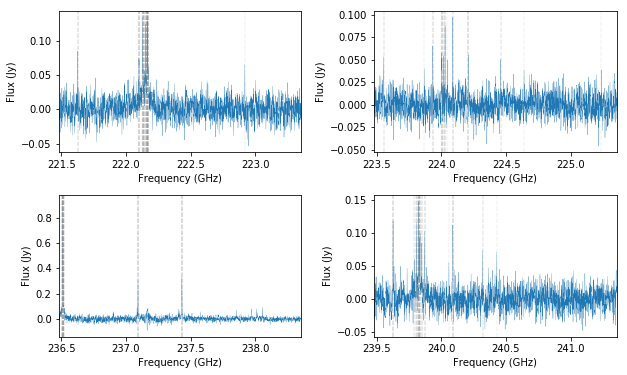

In [6]:
# Options
show_plot = False   # Whether or not to show the plot (doesn't seem to work in Jupyter Notebooks...)
show_output = True  # Whether or not to view the all_molecules dictionary

# Generte the plot if necessary
if generate_plot:
    fig, axs = create_plot()
    axs = axs.flat

# If all_molecules wasn't loaded in, generate and save it by running the find_molecules function
if "all_molecules" not in locals():
    all_molecules = {}  # This will store the molecule name and every frequency it is found at
    find_molecules()
    
    # Save the all_molecules dictionary
    pd.DataFrame.from_dict(all_molecules,
                           columns = ["Molecule Tag",
                                      "Linelist",
                                      "Occurances"],
                           orient = "index").to_csv("./Data/all_molecules.csv")

# Output
View whichever results were specified in the Main Script section.

In [7]:
if show_plot:
    plt.show()
    
if show_output:
    print("{:<15} {:<15} {:<10} Occurances".format('Molecule','Molecule Tag','Linelist'))
    for molecule, values in all_molecules.items():
        tag = all_molecules[molecule]["Molecule Tag"]
        linelist = all_molecules[molecule]["Linelist"]
        occurances = all_molecules[molecule]["Occurances"]
        print("{}".format(molecule))
        print("{:<15} {:<15} {:<10} {}".format("", tag, linelist, occurances))

Molecule        Molecule Tag    Linelist   Occurances
Unknown
                None            None       [221.62518, 221.62567, 222.09885, 222.09933, 222.12766, 222.12814, 222.13107, 222.13156, 222.14914, 222.15012, 222.1511, 222.16086, 222.16135, 222.16233, 222.1633, 222.16526, 222.16623, 222.1677, 222.16867, 222.17209, 222.91824, 223.55306, 223.86705, 223.93297, 224.00182, 224.00231, 224.0028, 224.00329, 224.00378, 224.01745, 224.02868, 224.08777, 224.08874, 224.20643, 224.20692, 225.23629, 236.50864, 236.51011, 236.5106, 236.51109, 236.51157, 236.51206, 236.51255, 236.51353, 236.51402, 236.51548, 236.51597, 236.51792, 236.51939, 237.09267, 237.09365, 237.09462, 237.43156, 237.43254, 239.62705, 239.62753, 239.80968, 239.81016, 239.82433, 239.8253, 239.82579, 239.83019, 239.83067, 239.83116, 239.83409, 239.83653, 239.84923, 239.85021, 240.08899, 240.09046, 240.31899]
Bromine Dioxide
                111001          JPL        [221.62616, 222.14182, 223.93395]
Silicon monosulfide
      

In [12]:
all_molecules

{'Unknown': {'Molecule Tag': None,
  'Linelist': None,
  'Occurances': [221.62518,
   221.62567,
   222.09885,
   222.09933,
   222.12766,
   222.12814,
   222.13107,
   222.13156,
   222.14914,
   222.15012,
   222.1511,
   222.16086,
   222.16135,
   222.16233,
   222.1633,
   222.16526,
   222.16623,
   222.1677,
   222.16867,
   222.17209,
   222.91824,
   223.55306,
   223.86705,
   223.93297,
   224.00182,
   224.00231,
   224.0028,
   224.00329,
   224.00378,
   224.01745,
   224.02868,
   224.08777,
   224.08874,
   224.20643,
   224.20692,
   225.23629,
   236.50864,
   236.51011,
   236.5106,
   236.51109,
   236.51157,
   236.51206,
   236.51255,
   236.51353,
   236.51402,
   236.51548,
   236.51597,
   236.51792,
   236.51939,
   237.09267,
   237.09365,
   237.09462,
   237.43156,
   237.43254,
   239.62705,
   239.62753,
   239.80968,
   239.81016,
   239.82433,
   239.8253,
   239.82579,
   239.83019,
   239.83067,
   239.83116,
   239.83409,
   239.83653,
   239.84923,